In [105]:

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn

# Practica 6 Redes Neuronales
## Miguel Angel Carvajal
### Ejercicio 1

Defino la matrix de covarianza $\Sigma$

In [6]:
cov_mat = np.ones((4,4))
np.fill_diagonal(cov_mat,2)
print cov_mat

[[ 2.  1.  1.  1.]
 [ 1.  2.  1.  1.]
 [ 1.  1.  2.  1.]
 [ 1.  1.  1.  2.]]


In [7]:
# learning speed
eta = 0.0001

#### Draw the network achitecture

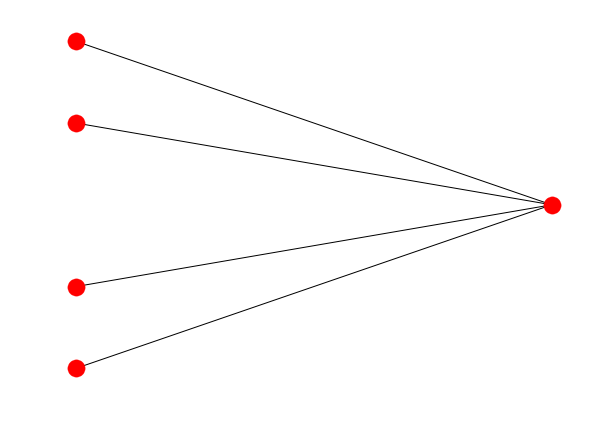

In [106]:
nn =  nx.Graph()
nn.add_nodes_from([1,2,3,4,5])
nn.add_edges_from([(1,5),(2,5),(3,5),(4,5)])
nx.draw(nn, pos={1:(0,2),2:(0,1),3:(0,-1),4:(0,-2),5:(1,0)})
plt.plot()
plt.show()

## Run the simulation
The input data is generated with a multigaussian probability given by

$P(\bar{\xi}) = \frac{1}{(2\pi)^2 \sqrt{\det(\xi)}}\exp(-\frac{1}{2}\bar{\xi^T}\Sigma^{-1}\bar{\xi})$


In [9]:
np.random.seed(1)
N_in = 4 # input size
N_out = 1 # output size
# init weights
weights = (2*np.random.rand(4,1)-1) /10 
mean_val = np.zeros(N_in)
p = 30000
# print weights.shape
D_in = np.random.multivariate_normal(mean_val,cov_mat,p)
for i in range(0,p):
    D_in_i = D_in[i:i+1,:]
#     print D_in_i.shape
    V = np.dot(weights.T,D_in_i.T)
    error = eta * V * (D_in_i.T -  V*weights)
#     print error.shape
#     print np.mean(np.abs(error))
    weights += error
print weights

[[-0.49392035]
 [-0.49219265]
 [-0.51130988]
 [-0.50250419]]


Check that the coverged weight has norm 1

In [10]:
norm =np.sum(weights**2)
print norm

1.0001591745


Diagonalize the covarianza matriz and find the biggest eigenvalue

In [11]:
vals, vectors = np.linalg.eig(cov_mat)
print vals

[ 1.  5.  1.  1.]


The biggest eigenvalue is 5. and the eigenvector associated with it is

In [12]:
y  = vectors[:,1]
print y
print weights[:,0]

[ 0.5  0.5  0.5  0.5]
[-0.49392035 -0.49219265 -0.51130988 -0.50250419]


Comparando el resultado obtenido con el autovector de la matriz correspondiente al *mayor autovalor* se observa que estos tienen la misma dirección.

### Ejercicio 2

Considere una red neuronal de Kohonen con dos neuronas de entrada.
Utilice 10 neuronas de salida, dispuestas sobre una línea. Alimente a
las neuronas de entrada con una distribución

#### Define the neighboring function

In [13]:
def neigh(sigma):
    def neig_impl(i,k):
        return np.exp(-(i - k )**2/(2* sigma**2))
    return neig_impl

f1 = neigh(1)
assert f1(1,1) == 1 # must be one for the same neurons


In [14]:

def scale(initial, final):
    """ Scale an interval (x1,x2) to (y1,y2)"""
    x1, x2 = initial
    y1, y2 = final
    slope = (y2 - y1)/(x2 - x1)
    intercept  = y1 - slope * x1
    def linf(x):
        assert x >=  x1, "invalid input value " + str(x)
        assert x <=  x2, "invalid input value " + str(x)
        retval = x * slope + intercept
        assert retval >= y1
        assert retval <= y2
        return retval
    return linf    

In [25]:
def to_radial_coords(point):
    """ convert a point from linear coordiates to radial coordiantes
        returns:  numpy array with[r,theta]
    """
    assert point.shape == (2,), "error on shape: " + str(point.shape)
    x = point[0]
    y = point[1]
    r =  np.sqrt(x**2 + y**2)
    assert r <= np.sqrt(2), point
    angle =  np.arctan2(y,x)
    return np.array([r,angle])
def to_linear_coords(point):
    r = point[0]
    theta = point[1]
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.array([x,y])


In [115]:
p = 3000 # num datapoints
rmin = 0.9
rmax = 1.1

# define the dimensions of the input and output layer
N1 = 2
N2 = 10
# initalize the weights
weights = 2*np.random.rand(N1,N2)-1
norms =  np.linalg.norm(weights,axis=0)
# normalize the weights
for i in range(0,N2):
    weights[:,i] = weights[:,i] / norms[i]

data_points = (2*np.random.rand(N1,p) -1)
# convert to radial coords
radial_scale = scale((0,np.sqrt(2)), (rmin,rmax))
angular_scale = scale((-np.pi,np.pi), (0, np.pi))
for i in range(0,p):
    data_points[:,i] = to_radial_coords(data_points[:,i])
    data_points[0,i] = radial_scale(data_points[0,i])
    data_points[1,i] = angular_scale(data_points[1,i])

assert np.max(data_points[0, :]) <= np.sqrt(2) ,np.max(data_points[0, :])
assert np.min(data_points[0, :]) >= rmin
assert np.min(data_points[1, :]) >= -np.pi
assert np.max(data_points[0, :]) <= rmax, "error for max boundary " + str( np.max(data_points[:,0]))
assert np.max(data_points[1, :]) <= np.pi

neighf = neigh(0.1)

for i in range(0,p):
    x = to_linear_coords(data_points[:,i])
    h = np.dot(weights.T,x)
    k = np.argmax(h) # get the pos of the max element
    for j in range(0,N2):
        error =  neighf(j,k)*(x - weights[:,j])
        weights[:,j] += error
for i in range(0,N2):
    weights[:,i] = to_radial_coords(weights[:,i])


#### Plot the input data 

The data is distributed in an arc from $0$ to $\pi$

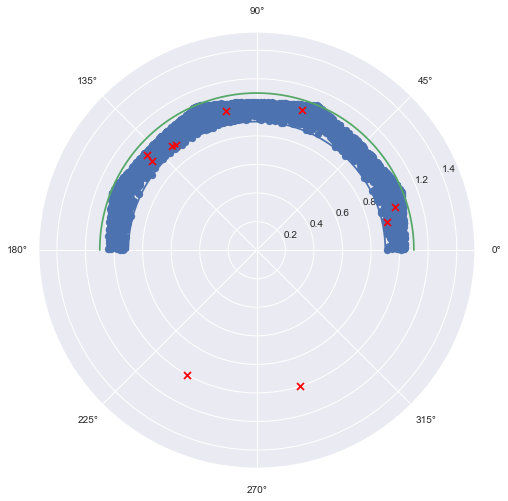

In [117]:
fig = plt.figure(figsize=(8,8))
fig.clear()
p1 = fig.add_subplot(111, projection='polar')
p1.scatter(data_points[1,:], data_points[0,:])
p1.scatter(weights[1,:], weights[0,:],color='r', marker='x')
plt.plot(np.pi*np.linspace(0,1,100), rmin*np.ones(100))
plt.plot(np.pi*np.linspace(0,1,100), rmax*np.ones(100))
plt.show()

Now wrap everything inside a function with p and $\sigma$ as parameters

In [118]:
def kohonen_simulation(sigma,p):
    rmin = 0.9
    rmax = 1.1

    # define the dimensions of the input and output layer
    N1 = 2
    N2 = 10
    # initalize the weights
    weights = 2*np.random.rand(N1,N2)-1
    norms =  np.linalg.norm(weights,axis=0)
    # normalize the weights
    for i in range(0,N2):
        weights[:,i] = weights[:,i] / norms[i]

    data_points = (2*np.random.rand(N1,p) -1)
    # convert to radial coords
    radial_scale = scale((0,np.sqrt(2)), (rmin,rmax))
    angular_scale = scale((-np.pi,np.pi), (0, np.pi))
    for i in range(0,p):
        data_points[:,i] = to_radial_coords(data_points[:,i])
        data_points[0,i] = radial_scale(data_points[0,i])
        data_points[1,i] = angular_scale(data_points[1,i])

    assert np.max(data_points[0, :]) <= np.sqrt(2) ,np.max(data_points[0, :])
    assert np.min(data_points[0, :]) >= rmin
    assert np.min(data_points[1, :]) >= -np.pi
    assert np.max(data_points[0, :]) <= rmax, "error for max boundary " + str( np.max(data_points[:,0]))
    assert np.max(data_points[1, :]) <= np.pi

    neighf = neigh(sigma)

    for i in range(0,p):
        x = to_linear_coords(data_points[:,i])
        h = np.dot(weights.T,x)
        k = np.argmax(h) # get the pos of the max element
        for j in range(0,N2):
            error =  neighf(j,k)*(x - weights[:,j])
            weights[:,j] += error

    for i in range(0,N2):
        weights[:,i] = to_radial_coords(weights[:,i])
    return  data_points, weights

def plot_simulation_results(p1,data_points, weights,sigma):
    """ Make a polar graph of the simulation results"""
    
    p1.scatter(data_points[1,:], data_points[0,:],marker= 'o')
    p1.set_title( r'$\sigma= %f$'%(sigma))
    p1.scatter(weights[1,:], weights[0,:],color='r', marker= 'x')

    plt.plot(np.pi*np.linspace(0,1,100), rmin*np.ones(100))
    plt.plot(np.pi*np.linspace(0,1,100), rmax*np.ones(100))



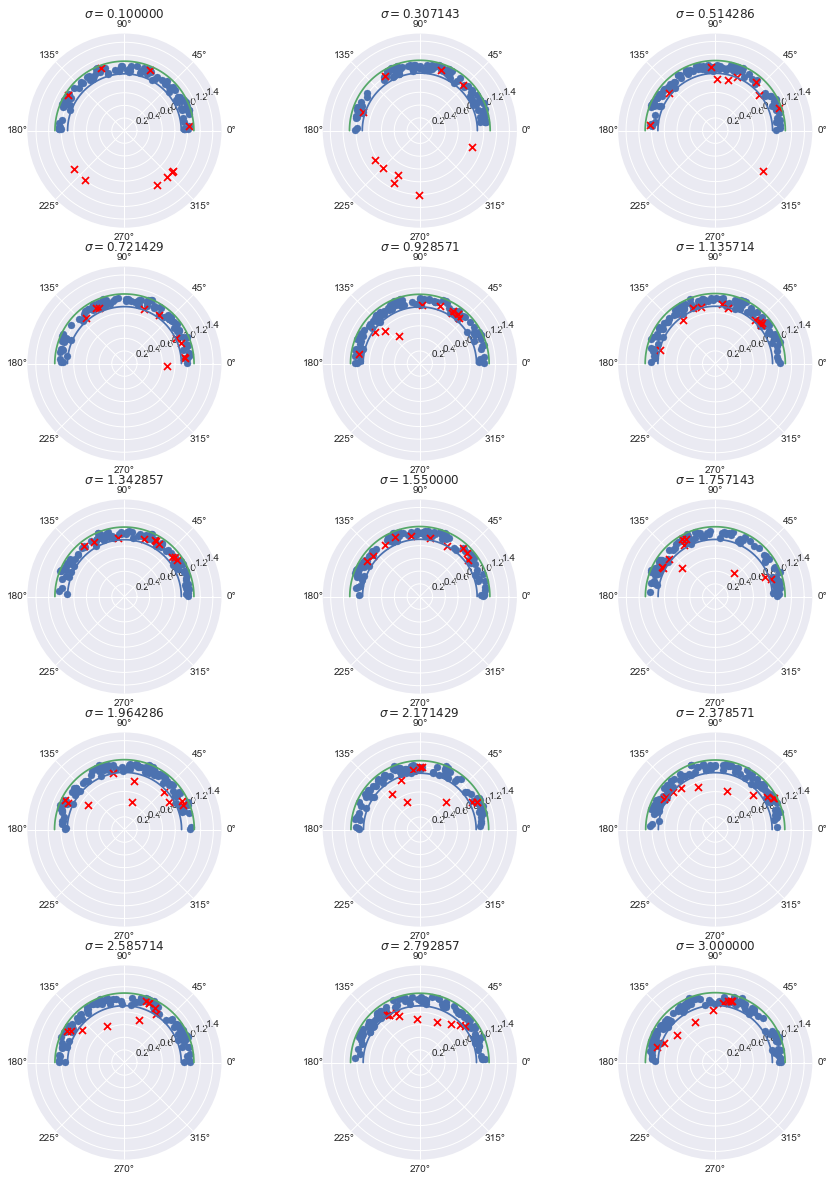

In [119]:
n = 15
sigmas = np.linspace(0.1,3,n)
p = 100
fig = plt.figure(figsize=(15,25))
fig.clear()
for k in range(0,n):
    data_points, weights = kohonen_simulation(sigmas[k],p)
    axes = fig.add_subplot(int(n/3) + 1,3,k+1, projection='polar')
    plot_simulation_results(axes,data_points, weights,sigmas[k])

plt.show()

En el grafico de arriba se muestra el resultado del aprendizaje para diferentes calores de $\sigma$. Se puede ver que para valores pequeños y grandes se obtiene un resultado peor, mientras que para valores cercanos a 1 se obtienen los mejores resultados.
